# Analyze test data

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as patches
import glob
import os
import sys
import cv2
from PIL import Image
from collections import defaultdict
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error

sys.path.append("/home/mojjaf/pix2pix_self_norm/Pix2Pix-Tensorflow-SelfNormalization/Pix2Pix_V.02/") # location where functions.py is ***NEED TO CHANGE THIS TO YOUR OWN LOCATION
from functions import * # import all functions in functions.py

(85, 85, 3)
(85, 85)
Min: -1.000, Max: 1.000
Min: -1.000, Max: 1.000


2022-07-09 11:37:00.547464: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-09 11:37:05.125326: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30984 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:1b:00.0, compute capability: 7.0
2022-07-09 11:37:05.128081: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 30984 MB memory:  -> device: 1, name: Tesla V100-SXM2-32GB, pci bus id: 0000:1c:00.0, compute capability: 7.0
2022-07-09 11:37:05.130611: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:

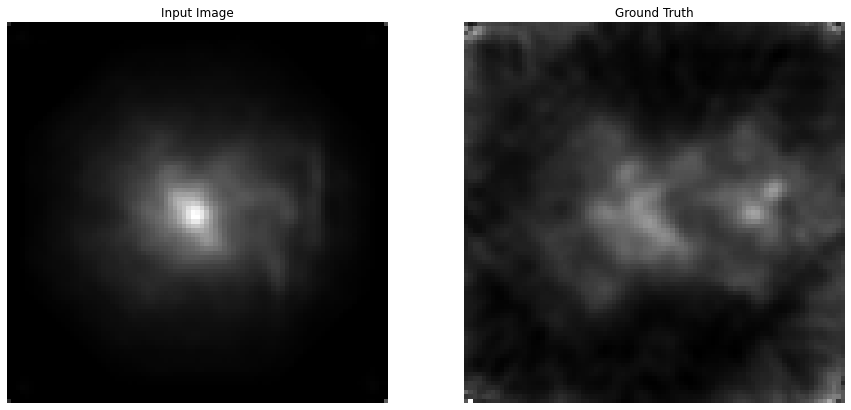

In [2]:
import h5py
import tensorflow as tf
def normalise_per_channel(image):
    rank = 3
    ch_mins = np.amin(image, axis=tuple(range(rank - 1)))
    ch_maxs = np.amax(image, axis=tuple(range(rank - 1)))
    ch_range = ch_maxs - ch_mins
    
    img = (image - ch_mins) / ch_range
    image_norm = 2*img - 1
    
    return image_norm


def normalize(input_image, real_image):
    input_image=normalise_per_channel(input_image)
    real_image=normalise_per_channel(real_image)

    return input_image, real_image

def load(image_file):
    # Read and decode an image file to a uint8 tensor
    img = h5py.File(image_file,'r')
    key = list(img.keys())[0]
    image = img[key][:]
    image = np.array(image)
    image = tf.cast(image, tf.float32)
    return image


# In[14]: In the case of 3 to 1, we have two problems:
#1) input image is 90 degree rotated and 2) input image has 3 channels but it has been  normalized! 
#It should be so that input has dim (85,85,3) but uncorrected and output (85,85) and corrected/normalized

image_dirB ='/home/mojjaf/pix2pix_self_norm/reorganized_data/self_norm_dataset/uncorrected_byPatient_3to1_h5/B/test/10_crysEff_2_iter_22_10_lesion.h5'
image_dirA ='/home/mojjaf/pix2pix_self_norm/reorganized_data/self_norm_dataset/uncorrected_byPatient_3to1_h5/A/test/10_crysEff_2_iter_22_10_lesion.h5'
image_re =load(image_dirA)
image_inp =load(image_dirB)

print(np.shape(image_inp))
print(np.shape(image_re))

image_inp_norm,image_re_norm=normalize(image_inp,image_re)
print('Min: %.3f, Max: %.3f' % (np.min(image_inp_norm), np.max(image_inp_norm)))
print('Min: %.3f, Max: %.3f' % (np.min(image_re_norm), np.max(image_re_norm)))

image_inp_norm=np.array(image_inp_norm)
image_re_norm=np.array(image_re_norm)
plt.figure(figsize=(15, 15))
#print(np.shape(test_input))
title = ['Input Image', 'Ground Truth']
#unnorm = (255*(image_inp_norm - np.min(image_inp_norm))/np.ptp(image_inp_norm)).astype(int) 
#norm = (255*(image_re_norm - np.min(image_re_norm))/np.ptp(image_re_norm)).astype(int) 

unnorm=(image_inp_norm)
norm=(image_re_norm)
display_list = [ image_inp[...,0],image_re]

for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i], cmap='gray')
    plt.axis('off')
    
plt.show()


Min: 0.000, Max: 255.000
Min: 0.000, Max: 255.000
Min: 0.000, Max: 255.000
Min: 0.000, Max: 255.000
Min: 0.000, Max: 255.000
Min: 0.000, Max: 255.000


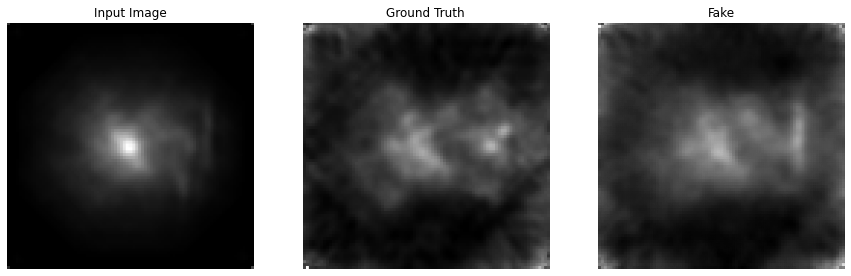

In [3]:
#Pix2Pix_uncorrected_byPatient_1to1_h5_20220701-083405
#Pix2Pix_uncorrected_byPatient_3to3_h5_20220701-082800
#Pix2Pix_uncorrected_byPatient_3to3_h5_20220701-163259 80 epochs
image_dirA ='./experiments/Pix2Pix_uncorrected_byPatient_3to1_h5_20220708-191109/pix2pix2.5D_predictions/10_crysEff_2_iter_20_10_lesio_real_A.npy'
image_dirB ='./experiments/Pix2Pix_uncorrected_byPatient_3to1_h5_20220708-191109/pix2pix2.5D_predictions/10_crysEff_2_iter_20_10_lesio_real_B.npy'
image_dirFake= './experiments/Pix2Pix_uncorrected_byPatient_3to1_h5_20220708-191109/pix2pix2.5D_predictions/10_crysEff_2_iter_20_10_lesio_fake_B.npy'
image_re =np.asarray(np.load(image_dirB))
image_inp =np.asarray(np.load(image_dirA))
image_fake=np.asarray(np.load(image_dirFake))
print('Min: %.3f, Max: %.3f' % (np.min(image_inp), np.max(image_inp)))
print('Min: %.3f, Max: %.3f' % (np.min(image_re), np.max(image_re)))
print('Min: %.3f, Max: %.3f' % (np.min(image_fake), np.max(image_fake)))

plt.figure(figsize=(15, 15))
#print(np.shape(test_input))
title = ['Input Image', 'Ground Truth', 'Fake']
unnorm = (255*(image_inp - np.min(image_inp))/np.ptp(image_inp)).astype(int) 
norm = (255*(image_re - np.min(image_re))/np.ptp(image_re)).astype(int) 
fake = (255*(image_fake - np.min(image_fake))/np.ptp(image_fake)).astype(int) 

display_list = [unnorm[...,0],norm[...,0],fake[...,0]]

print('Min: %.3f, Max: %.3f' % (np.min(unnorm), np.max(unnorm)))
print('Min: %.3f, Max: %.3f' % (np.min(norm), np.max(norm)))
print('Min: %.3f, Max: %.3f' % (np.min(fake), np.max(fake)))

for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i], cmap='gray')
    plt.axis('off')
    
plt.show()

In [11]:
np.shape(norm)

(256, 256, 1)

## User parameters

In [98]:
#path = "./test_results_fullDS_wCrystalEff_bs1_40ep_doubleattention/" #multiple attention
#path= "./test_results_fullDS_wCrystalEff_bs1_40ep_doubleattention_ResUnet/"# resUnet+multiple attention
#path="./test_results_fullDS_wCrystalEff_bs1_40ep/" #pix2pix
#Pix2Pix_uncorrected_byPatient_1to1_h5_20220701-083405
#Pix2Pix_uncorrected_byPatient_3to3_h5_20220701-163259 89 epochs
#Pix2Pix_uncorrected_byPatient_3to1_h5_20220706-214034 80 epochs 
path="./experiments/Pix2Pix_uncorrected_byPatient_3to1_h5_20220706-214034/pix2pix2.5D_predictions/"
iterList = [2*(i + 1) for i in range(20)] # iteration numbers
print("iterList: {}".format(iterList))

Alabel = "unnorm." # label for plots
Blabel = "norm.(pred.)"

# Lesion 
# We have 10 patient simulation data sets and 12 sphere simulation data sets. Last two patient data sets have two spehres each. 
# cf. 7th and 9th sphere went to patient 9 and 8th and 10th sphere went to patient 10
sphereLoc = [(35, 64, 9), (15, 48, 2), (33, 54, 10), (36, 62, 9), \
             (50, 58, 8), (29, 52, 7), (49, 59, 5), (29, 26, 11), \
             (37, 21, 6), (58, 60, 6), (20, 36, 11), (37, 69, 10)] 
#sphereLoc = [(y,x,z) for x,y,z in sphereLoc]
lw = lh = 15 # lesion width and height in pixel unit. one pixel is about 0.66 mm

# ROI
rw = rh = 40 # ROI width and height (unit: pixel) 


# Background
bw = bh = 150 # Background width and height (unit: pixel)

fov = [170, 170, 40] # unit: mm

iterList: [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40]


### Parameter pre-processing

In [99]:
loc = dict() # key: simID_sliceNum / value: (x, y) of spheres 
for i in range(len(sphereLoc)):
    if i == 10 or i == 11:
        idx = str(i-1) + "_" + str(sphereLoc[i][2])
        loc[idx] = tuple([j for j in sphereLoc[i]][:2])
    else:
        idx = str(i+1) + "_" + str(sphereLoc[i][2])
    loc[idx] = [j for j in sphereLoc[i]][:2]
    loc[idx] = [int(loc[idx][0]/85.0*256.0), int((85.0-loc[idx][1])/85.0*256.0)]
print("sphere location for each id: {}".format(loc))

sphere location for each id: {'1_9': [105, 63], '2_2': [45, 111], '3_10': [99, 93], '4_9': [108, 69], '5_8': [150, 81], '6_7': [87, 99], '7_5': [147, 78], '8_11': [87, 177], '9_6': [111, 192], '10_6': [174, 75], '9_11': [60, 147], '10_10': [111, 48]}


## Read png files as numpy array and organize

### Create a nested dictionary

Basic idea is that I wanted to group data into different iteration numbers first. And then, for each iteration number group, I wanted to make subgroup for id_crysEffId_sliceNum. And then for each of those, we have realA, realB, and fakeB.

First layer = key: iterNum / value: dict

Second layer = key: idx ("id_crysEffId_sliceNum") / value: dict

Third layer = key: "realA/realB/fakeB" / value: image in 2d numpy array 

In [100]:
data = defaultdict(lambda: defaultdict(dict)) #three-layer dict
fileList = [f for f in glob.glob(path+"*") if os.path.isfile(f)]
for f in fileList:
    image=np.asarray(np.load(f))
    #image=cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)
    w, h, c=np.shape(image)
    image = np.mean(image.reshape((256, 256, c)), axis=2)# 3 or 1
    image -= np.min(image)
    image /= (np.max(image) - np.min(image))
    name = f.split("/")[-1].split(".")[0]
    iterNum = name.split("_")[4]
    idx = name.split("_")[0] + "_" + name.split("_")[2] + "_" + name.split("_")[5] # id_crysEffId_sliceNum
    category = name.split("_")[-2] + name.split("_")[-1] # realA / realB / fakeB
    data[iterNum][idx][category] = image

In [101]:
fileList

['./experiments/Pix2Pix_uncorrected_byPatient_3to1_h5_20220706-214034/pix2pix2.5D_predictions/10_crysEff_1_iter_28_1_real_A.npy',
 './experiments/Pix2Pix_uncorrected_byPatient_3to1_h5_20220706-214034/pix2pix2.5D_predictions/10_crysEff_1_iter_28_1_real_B.npy',
 './experiments/Pix2Pix_uncorrected_byPatient_3to1_h5_20220706-214034/pix2pix2.5D_predictions/10_crysEff_1_iter_28_1_fake_B.npy',
 './experiments/Pix2Pix_uncorrected_byPatient_3to1_h5_20220706-214034/pix2pix2.5D_predictions/7_crysEff_2_iter_20_1_real_A.npy',
 './experiments/Pix2Pix_uncorrected_byPatient_3to1_h5_20220706-214034/pix2pix2.5D_predictions/7_crysEff_2_iter_20_1_real_B.npy',
 './experiments/Pix2Pix_uncorrected_byPatient_3to1_h5_20220706-214034/pix2pix2.5D_predictions/7_crysEff_2_iter_20_1_fake_B.npy',
 './experiments/Pix2Pix_uncorrected_byPatient_3to1_h5_20220706-214034/pix2pix2.5D_predictions/10_crysEff_2_iter_2_10_lesio_real_A.npy',
 './experiments/Pix2Pix_uncorrected_byPatient_3to1_h5_20220706-214034/pix2pix2.5D_predi

### Check correctness

In [102]:
#print(data.keys())
#print(data["10"].keys())
#print(data["10"]["10_2_6"].keys())

## Calculate PSNR

In [103]:
PSNR_in = defaultdict(list) # compare input and target
PSNR_gen = defaultdict(list) # compare prediction and target
for iterNum in data:
    for idx in data[iterNum]:
        PSNR_in[iterNum].append(getPSNR(data[iterNum][idx]["realA"], data[iterNum][idx]["realB"]))
        PSNR_gen[iterNum].append(getPSNR(data[iterNum][idx]["fakeB"], data[iterNum][idx]["realB"]))
PSNR_in_avg = np.mean([np.mean(PSNR_in[k]) for k in PSNR_in if int(k) >= 10])
PSNR_gen_avg = np.mean([np.mean(PSNR_gen[k]) for k in PSNR_gen if int(k) >= 10])
print("mean PSNR_in after 10 or more iter: {:.2f}".format(PSNR_in_avg))
print("mean PSNR_gen after 10 or more iter: {:.2f}".format(PSNR_gen_avg))
print("")
print("improved by {:.2f}% (w.r.t input)".format((PSNR_gen_avg - PSNR_in_avg)/(PSNR_in_avg)*100))

mean PSNR_in after 10 or more iter: 17.30
mean PSNR_gen after 10 or more iter: 22.15

improved by 28.00% (w.r.t input)


### Plot results

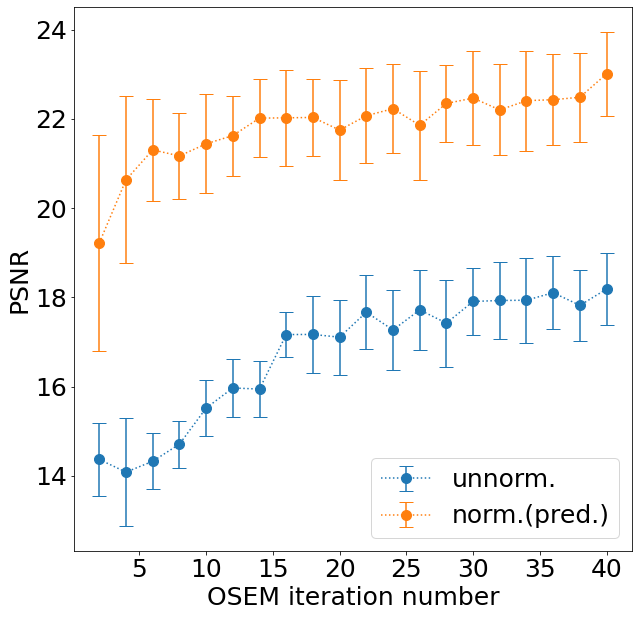

In [104]:
textSize = 25
x = iterList
keys = sorted([int(k) for k in PSNR_in])
y1 = [np.mean(PSNR_in[str(i)]) for i in keys]
yerr1 = [np.std(PSNR_in[str(i)])/2.0 for i in keys]
y2 = [np.mean(PSNR_gen[str(i)]) for i in keys]
yerr2 = [np.std(PSNR_gen[str(i)])/2.0 for i in keys]
figure = plt.figure(figsize=(10,10))
ax = figure.gca()
text = ax.yaxis.get_offset_text()
text.set_size(textSize) # Overkill!
plt.errorbar(x, y1, yerr1, fmt="o:", markersize=10, capsize=7, label=Alabel)
plt.errorbar(x, y2, yerr2, fmt="o:", markersize=10, capsize=7, label=Blabel)
plt.xlabel("OSEM iteration number", fontsize=textSize)
plt.ylabel("PSNR", fontsize=textSize)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
# plt.xticks(iterList, fontsize=textSize)
plt.xticks(fontsize=textSize)
plt.yticks(fontsize=textSize)
plt.legend(fontsize=textSize)
plt.show()

## Calculate NRMSE

### Debugging...

In [105]:
# a = np.array([[5.0,6.0],[7.0,8.0]])
# a -= np.min(a)
# a /= (np.max(a) - np.min(a))
# b = np.array([[1.0,2.0],[1.0,2.0]])
# b -= np.min(b)
# b /= (np.max(b) - np.min(b))
# print(a)
# print(b)
# def test(A, B):
#     # Assume A and B are numpy array
#     # RMSE will be normalized by mean of B
#     assert(A.size == B.size)
#     m = A.size
#     print(m)
#     return np.sqrt(np.sum(A - B)**2/m)/(np.mean(B))
# print(test(a,b))

### Create two dictionaries for NRMSE, realA - realB pair, and fakeB - realB pair

key: iterNum / value: list 

In [106]:
NRMSE_in = defaultdict(list) # compare input and target
NRMSE_gen = defaultdict(list) # compare prediction and target
for iterNum in data:
    for idx in data[iterNum]:
        NRMSE_in[iterNum].append(getNRMSE(data[iterNum][idx]["realA"], data[iterNum][idx]["realB"]))
        NRMSE_gen[iterNum].append(getNRMSE(data[iterNum][idx]["fakeB"], data[iterNum][idx]["realB"]))
NRMSE_in_avg = np.mean([np.mean(NRMSE_in[k]) for k in NRMSE_in if int(k) >= 10])
NRMSE_gen_avg = np.mean([np.mean(NRMSE_gen[k]) for k in NRMSE_gen if int(k) >= 10])
print("mean NRMSE_in after 10 or more iter: {:.2f}".format(NRMSE_in_avg))
print("mean NRMSE_gen after 10 or more iter: {:.2f}".format(NRMSE_gen_avg))
print("")
print("improved by {:.1f}% (w.r.t input)".format(-(NRMSE_gen_avg - NRMSE_in_avg)/(NRMSE_in_avg)*100))

mean NRMSE_in after 10 or more iter: 0.75
mean NRMSE_gen after 10 or more iter: 0.44

improved by 41.3% (w.r.t input)


### Plot result

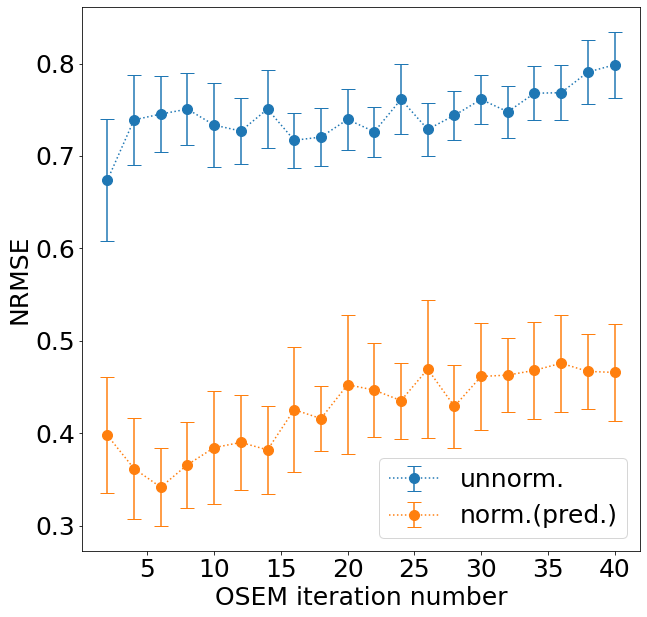

In [107]:
textSize = 25
x = iterList
keys = sorted([int(k) for k in NRMSE_in])
y1 = [np.mean(NRMSE_in[str(i)]) for i in keys]
yerr1 = [np.std(NRMSE_in[str(i)])/2.0 for i in keys]
y2 = [np.mean(NRMSE_gen[str(i)]) for i in keys]
yerr2 = [np.std(NRMSE_gen[str(i)])/2.0 for i in keys]
figure = plt.figure(figsize=(10,10))
ax = figure.gca()
text = ax.yaxis.get_offset_text()
text.set_size(textSize) # Overkill!
plt.errorbar(x, y1, yerr1, fmt="o:", markersize=10, capsize=7, label=Alabel)
plt.errorbar(x, y2, yerr2, fmt="o:", markersize=10, capsize=7, label=Blabel)
plt.xlabel("OSEM iteration number", fontsize=textSize)
plt.ylabel("NRMSE", fontsize=textSize)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
# plt.xticks(iterList, fontsize=textSize)
plt.xticks(fontsize=textSize)
plt.yticks(fontsize=textSize)
plt.legend(fontsize=textSize)
plt.show()

## Calculate SSIM

Create two dictionaries, one for two-view, another one for prediction

In [120]:
SSIM_in = defaultdict(list) # compare two-view(realA) and cylinder(realB)
SSIM_gen = defaultdict(list) # compare generated cylinder(fakeB) and real cylinder(realB)
for iterNum in data:
    for idx in data[iterNum]:
        data_range = np.max(data[iterNum][idx]["realB"]) - np.min(data[iterNum][idx]["realB"])
        SSIM_in[iterNum].append(ssim(data[iterNum][idx]["realA"], data[iterNum][idx]["realB"], data_range = data_range))
        SSIM_gen[iterNum].append(ssim(data[iterNum][idx]["fakeB"], data[iterNum][idx]["realB"], data_range = data_range))
SSIM_in_avg = np.mean([np.mean(SSIM_in[k]) for k in SSIM_in if int(k) >= 10])
SSIM_gen_avg = np.mean([np.mean(SSIM_gen[k]) for k in SSIM_gen if int(k) >= 10])
print("mean SSIM_in after 10 or more iter: {:.2f}".format(SSIM_in_avg))
print("mean SSIM_gen after 10 or more iter: {:.2f}".format(SSIM_gen_avg))
print("")
print("improved by {:.1f}% (w.r.t input)".format((SSIM_gen_avg - SSIM_in_avg)/(SSIM_in_avg)*100))

mean SSIM_in after 10 or more iter: 0.49
mean SSIM_gen after 10 or more iter: 0.77

improved by 57.6% (w.r.t input)


### Plot results

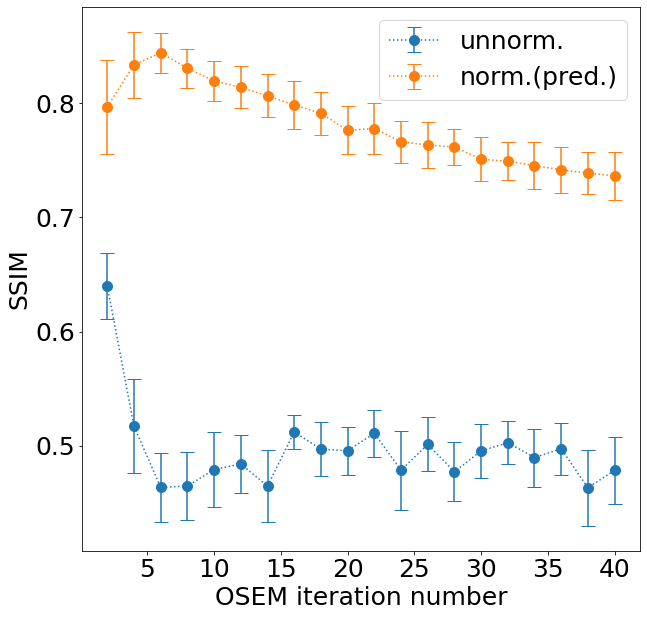

In [109]:
textSize = 25
x = iterList
keys = sorted([int(k) for k in SSIM_in])
y1 = [np.mean(SSIM_in[str(i)]) for i in keys]
yerr1 = [np.std(SSIM_in[str(i)])/2.0 for i in keys]
y2 = [np.mean(SSIM_gen[str(i)]) for i in keys]
yerr2 = [np.std(SSIM_gen[str(i)])/2.0 for i in keys]
figure = plt.figure(figsize=(10,10))
ax = figure.gca()
text = ax.yaxis.get_offset_text()
text.set_size(textSize) # Overkill!
plt.errorbar(x, y1, yerr1, fmt="o:", markersize=10, capsize=7, label=Alabel)
plt.errorbar(x, y2, yerr2, fmt="o:", markersize=10, capsize=7, label=Blabel)
plt.xlabel("OSEM iteration number", fontsize=textSize)
plt.ylabel("SSIM", fontsize=textSize)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
# plt.xticks(iterList, fontsize=textSize)
plt.xticks(fontsize=textSize)
plt.yticks(fontsize=textSize)
plt.legend(fontsize=textSize)
plt.show()

## PSNR and SSIM in same graph

Since we don't have enough space in the summary, I had to merge plots... see below

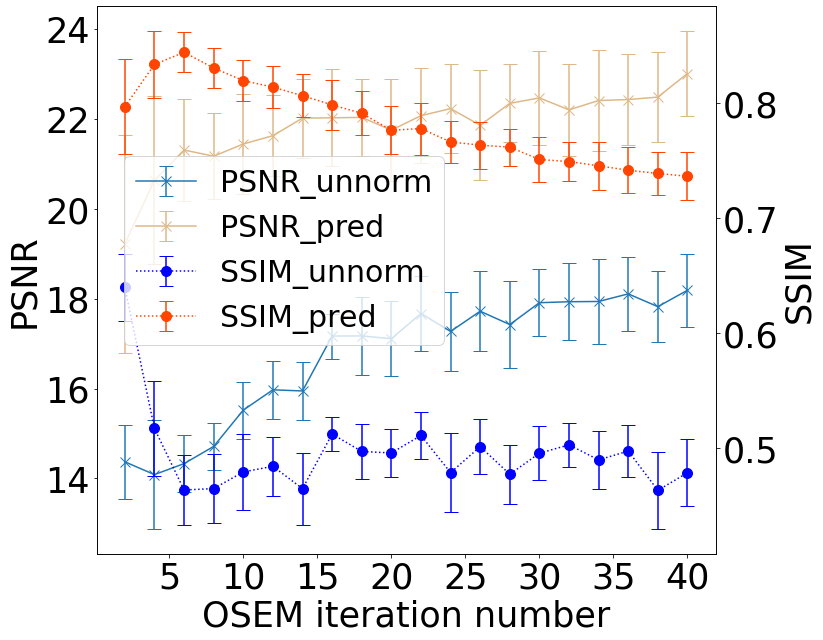

In [110]:
textSize = 35

x = iterList
keys_PSNR = sorted([int(k) for k in PSNR_in])
y1_PSNR = [np.mean(PSNR_in[str(i)]) for i in keys_PSNR]
yerr1_PSNR = [np.std(PSNR_in[str(i)])/2.0 for i in keys_PSNR]
y2_PSNR = [np.mean(PSNR_gen[str(i)]) for i in keys_PSNR]
yerr2_PSNR = [np.std(PSNR_gen[str(i)])/2.0 for i in keys_PSNR]
keys_SSIM = sorted([int(k) for k in SSIM_in])
y1_SSIM = [np.mean(SSIM_in[str(i)]) for i in keys_SSIM]
yerr1_SSIM = [np.std(SSIM_in[str(i)])/2.0 for i in keys_SSIM]
y2_SSIM = [np.mean(SSIM_gen[str(i)]) for i in keys_SSIM]
yerr2_SSIM = [np.std(SSIM_gen[str(i)])/2.0 for i in keys_SSIM]


fig, ax1 = plt.subplots()
fig.set_size_inches(12, 9)
ax1.set_xlabel('OSEM iteration number', fontsize=textSize)
ax1.set_ylabel('PSNR', fontsize=textSize)
ax1.errorbar(x, y1_PSNR, yerr1_PSNR, fmt="x-", markersize=10, capsize=7, label="PSNR_unnorm")
ax1.errorbar(x, y2_PSNR, yerr2_PSNR, fmt="x-", markersize=10, capsize=7, label="PSNR_pred", color="burlywood")
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.tick_params(axis='x', labelsize=textSize)
ax1.tick_params(axis='y', labelsize=textSize)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color_in = 'blue'
color_gen = 'orangered'
ax2.set_ylabel('SSIM', fontsize=textSize)
ax2.errorbar(x, y1_SSIM, yerr1_SSIM, fmt="o:", markersize=10, capsize=7, label="SSIM_unnorm", color=color_in)
ax2.errorbar(x, y2_SSIM, yerr2_SSIM, fmt="o:", markersize=10, capsize=7, label="SSIM_pred", color=color_gen)
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
ax2.tick_params(axis='x', labelsize=textSize)
ax2.tick_params(axis='y', labelsize=textSize)

fig.legend(fontsize=30, loc=(0.15,0.46))


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## ROI-specific analysis

### Organize slices including lesion

In [111]:
dataL = defaultdict(lambda: defaultdict(dict)) #three-layer dict for lesion only
fileList = [f for f in glob.glob(path+"*") if os.path.isfile(f)]
for f in fileList:
    name = f.split("/")[-1].split(".")[0]
    if name.split("_")[-3] != "lesio":
        continue
    iterNum = name.split("_")[4]
    simID = name.split("_")[0]
    crysEff = name.split("_")[2]
    sliceNum = name.split("_")[5]
    idx = simID + "_" + crysEff + "_" + sliceNum # id_crysEff_sliceNum
    category = name.split("_")[-2] + name.split("_")[-1] # realA / realB / fakeB
    
    image=np.asarray(np.load(f))
    #image=cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)
    image=np.fliplr(image)
    image=np.transpose(image, axes=(1,0,2))
    #image=np.flipud(image)
    w,h,c=np.shape(image)
    image = np.mean(image.reshape((256, 256, c)), axis=2)# 3 or 1
    image -= np.min(image)
    image /= (np.max(image) - np.min(image))
    l = loc[simID + "_" + sliceNum]
    dataL[iterNum][idx][category] = [image, l]

### Check data

In [112]:
# assert(len(dataL) == len(iterList))
# print(len(dataL["1"]))
# print(dataL["1"].keys())
# print(len(dataL["1"]["1_9"]))
# print(dataL["1"]["1_9"]["realB"][1])

## Print sample images

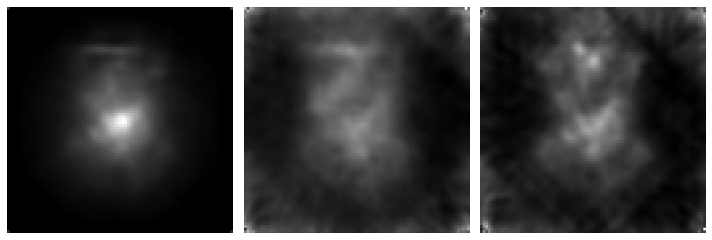

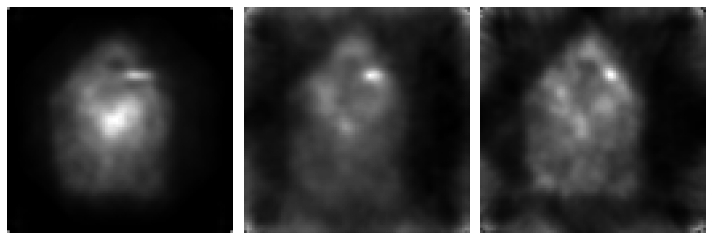

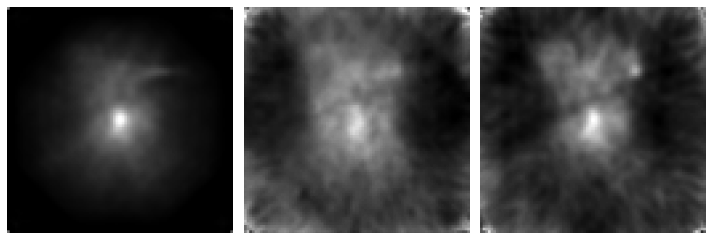

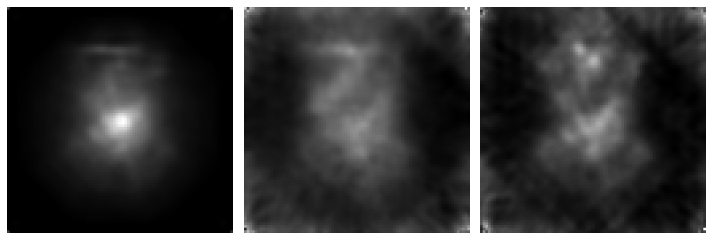

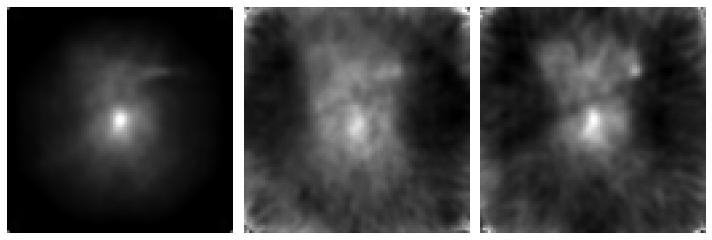

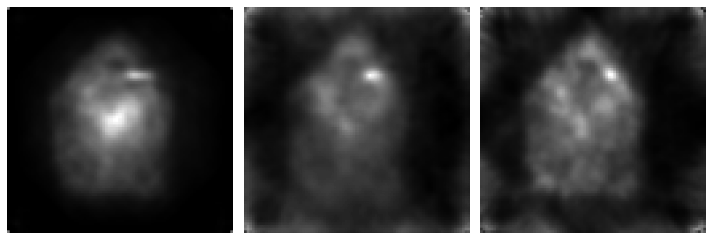

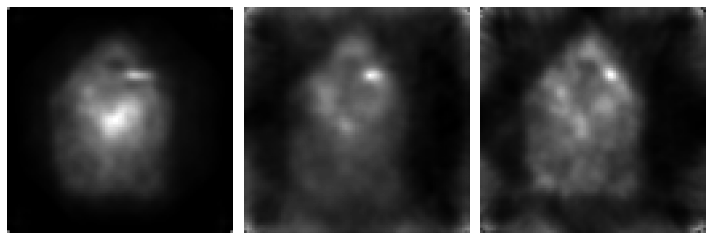

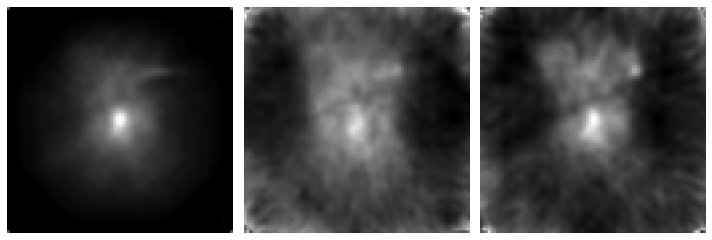

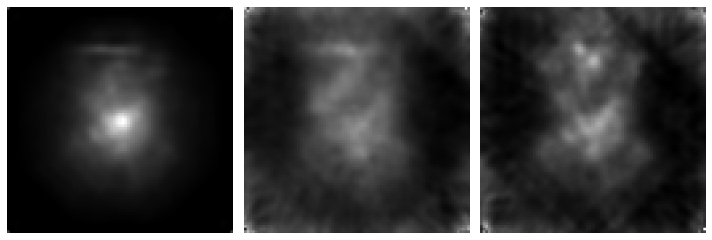

In [115]:
for iterNum in dataL:
    if iterNum == "20":
        for idx in dataL[iterNum]:
            image1 = dataL[iterNum][idx]["realA"][0]
            image2 = dataL[iterNum][idx]["fakeB"][0]
            image3 = dataL[iterNum][idx]["realB"][0]
            fig = plt.figure(figsize = (10, 10))
            ax1 = plt.subplot(1, 3, 1)
            ax1.imshow(image1, cmap=plt.get_cmap("gray"))
            ax1.axis("off")
            ax2 = plt.subplot(1, 3, 2)
            ax2.imshow(image2, cmap=plt.get_cmap("gray"))
            ax2.axis('off')
            ax3 = plt.subplot(1, 3, 3)
            ax3.imshow(image3, cmap=plt.get_cmap("gray"))
            ax3.axis('off')
            plt.tight_layout()
            plt.show()

### Check lesion location, lesion box, ROI, and background

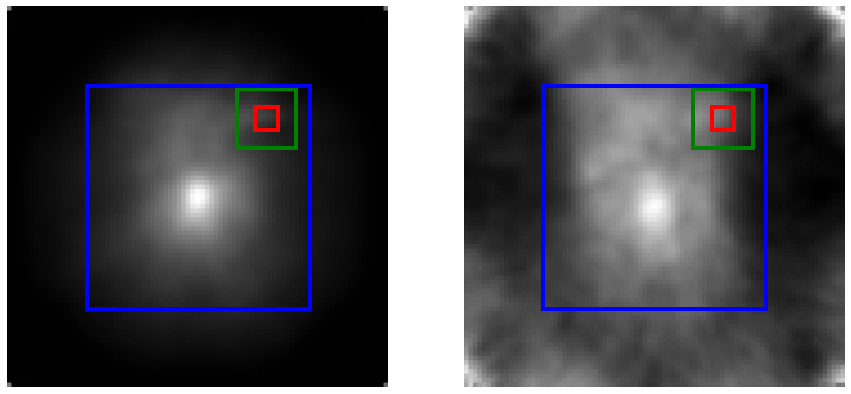

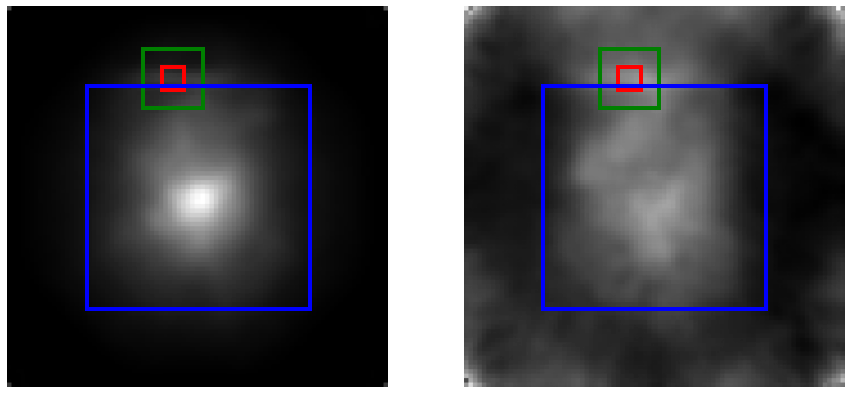

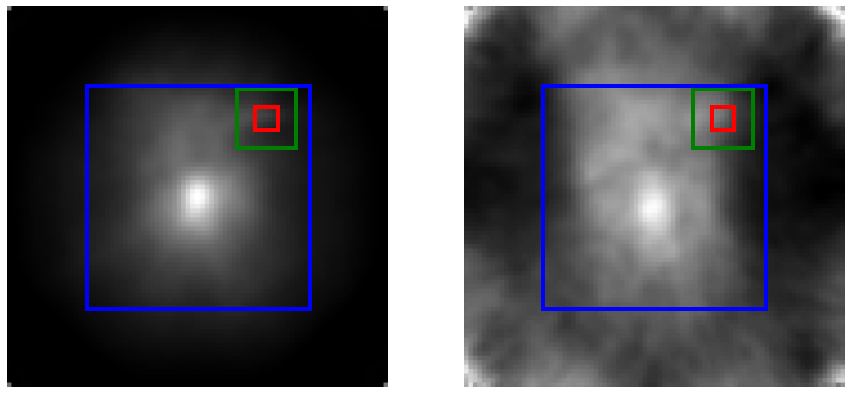

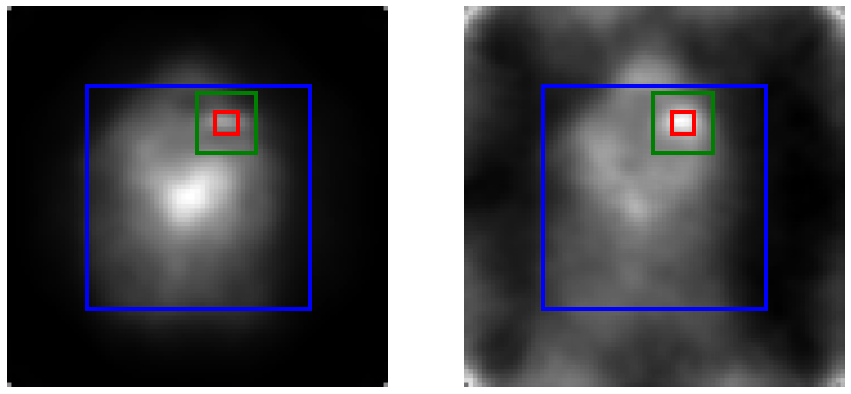

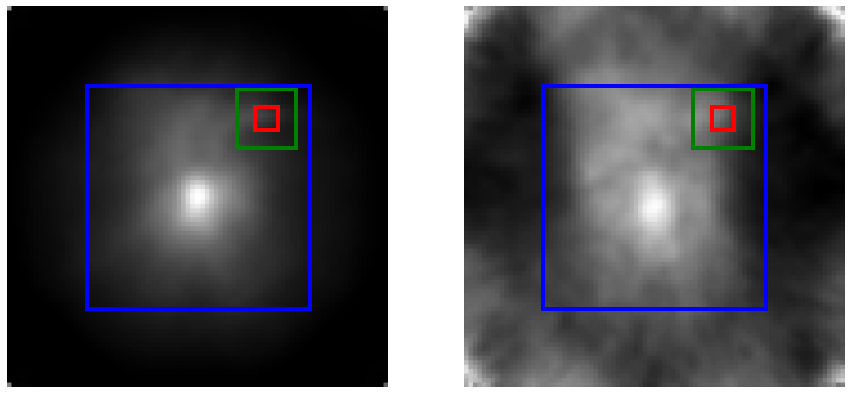

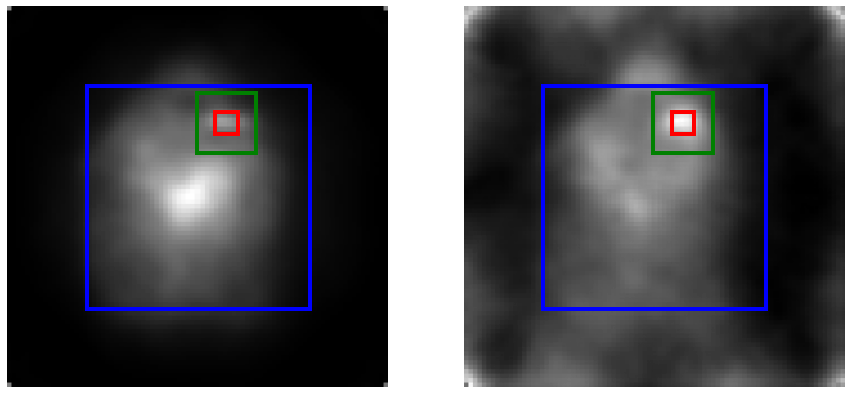

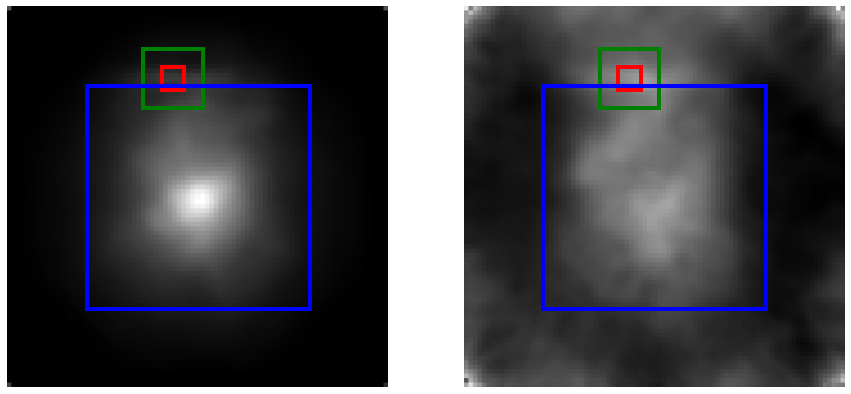

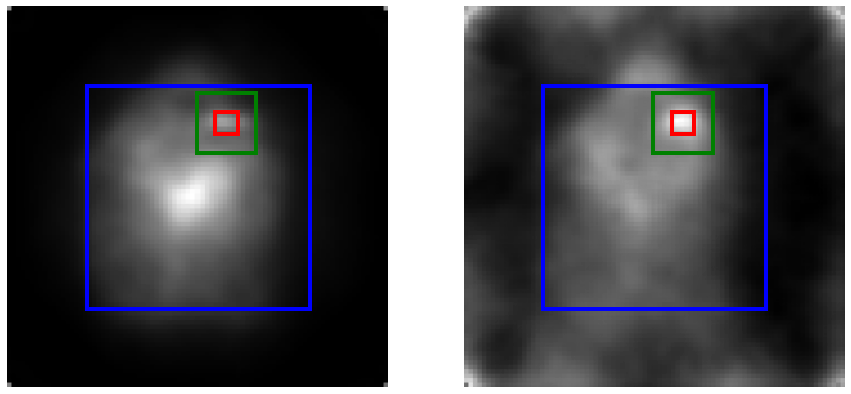

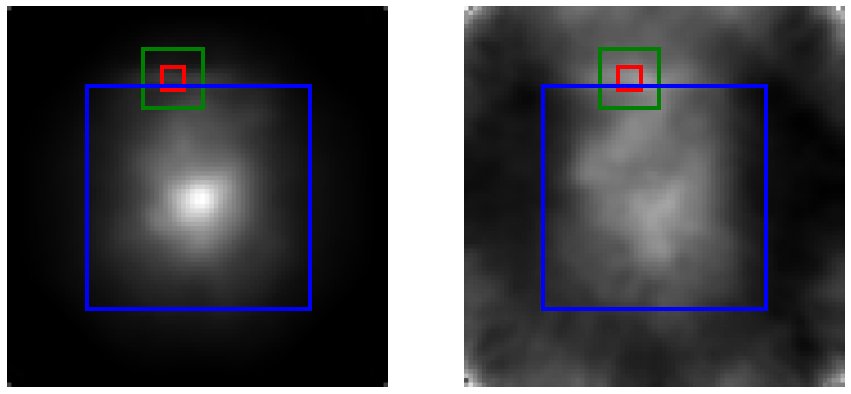

In [121]:
for iterNum in dataL:
    if iterNum == "10":
        for idx in dataL[iterNum]:
            image1 = dataL[iterNum][idx]["realA"][0]
            image2 = dataL[iterNum][idx]["fakeB"][0]
            x, y = dataL[iterNum][idx]["realA"][1] 
            fig = plt.figure(figsize = (15, 15))
            ax1 = plt.subplot(1, 2, 1)
            # Create a Rectangle patch
            rect = patches.Rectangle((x-lw/2, y-lh/2), lw, lh, linewidth=4, edgecolor='r', facecolor='none')
            ax1.add_patch(rect)
            rect = patches.Rectangle((x-rw/2, y-rh/2), rw, rh, linewidth=4, edgecolor='g', facecolor='none')
            ax1.add_patch(rect)
            rect = patches.Rectangle((256/2-bw/2, 256/2-bh/2), bw, bh, linewidth=4, edgecolor='b', facecolor='none')
            ax1.add_patch(rect)
#             ax1.scatter(x, y, color='r', s=2)
            ax1.imshow(image1, cmap=plt.get_cmap("gray"))
            ax1.axis("off")
            ax2 = plt.subplot(1, 2, 2)
            # Create a Rectangle patch
            rect = patches.Rectangle((x-lw/2, y-lh/2), lw, lh, linewidth=4, edgecolor='r', facecolor='none')
            ax2.add_patch(rect)
            rect = patches.Rectangle((x-rw/2, y-rh/2), rw, rh, linewidth=4, edgecolor='g', facecolor='none')
            ax2.add_patch(rect)
            rect = patches.Rectangle((256/2-bw/2, 256/2-bh/2), bw, bh, linewidth=4, edgecolor='b', facecolor='none')
            ax2.add_patch(rect)
#             ax2.scatter(x, y, color='r', s=2)
            ax2.imshow(image2, cmap=plt.get_cmap("gray"))
            ax2.axis('off')
            plt.show()

## NRMSE (ROI)

First layer = key: iterNum / value: dict

Second layer = key: idx ("id_crysEffs_sliceNum") / value: dict

Third layer = key: "realA/realB/fakeB" / value: a list of image in 2d numpy array and lesion location

In [86]:
NRMSEL_in = defaultdict(list) # compare input and target
NRMSEL_gen = defaultdict(list) # compare prediction and target
for iterNum in dataL:
    for idx in dataL[iterNum]:
        x, y = dataL[iterNum][idx]["realB"][1]
        x1 = int(x-rw/2)
        x2 = int(x+rw/2)
        y1 = int(y-rh/2)
        y2 = int(y+rh/2)
        NRMSEL_in[iterNum].append(getNRMSE(dataL[iterNum][idx]["realA"][0][y1:y2, x1:x2], dataL[iterNum][idx]["realB"][0][y1:y2, x1:x2]))
        NRMSEL_gen[iterNum].append(getNRMSE(dataL[iterNum][idx]["fakeB"][0][y1:y2, x1:x2], dataL[iterNum][idx]["realB"][0][y1:y2, x1:x2]))
NRMSEL_in_avg = np.mean([np.mean(NRMSEL_in[k]) for k in NRMSEL_in if int(k) >= 10])
NRMSEL_gen_avg = np.mean([np.mean(NRMSEL_gen[k]) for k in NRMSEL_gen if int(k) >= 10])
print("mean NRMSEL_in after 10 or more iter: {:.2f}".format(NRMSEL_in_avg))
print("mean NRMSEL_gen after 10 or more iter: {:.2f}".format(NRMSEL_gen_avg))
print("")
print("improved by {:.1f}% (w.r.t input)".format(-(NRMSEL_gen_avg - NRMSEL_in_avg)/(NRMSEL_in_avg)*100))

mean NRMSEL_in after 10 or more iter: 0.44
mean NRMSEL_gen after 10 or more iter: 0.22

improved by 50.2% (w.r.t input)


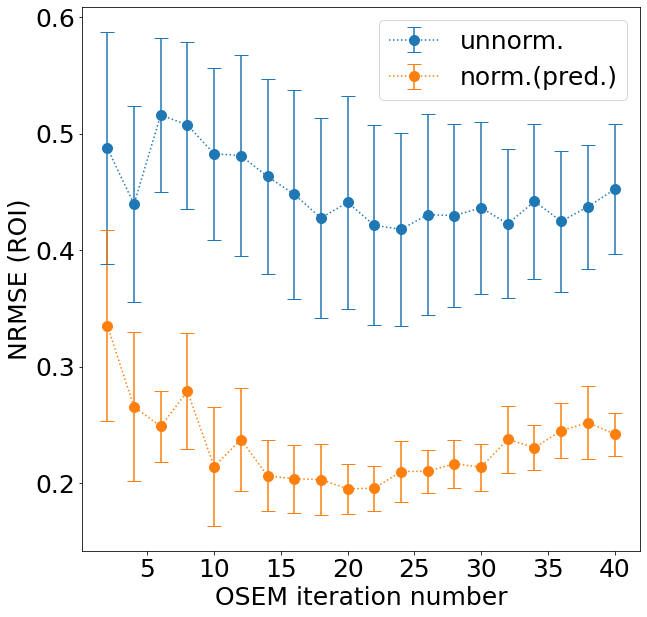

In [84]:
textSize = 25
x = iterList
keys = sorted([int(k) for k in NRMSEL_in])
y1 = [np.mean(NRMSEL_in[str(i)]) for i in keys]
yerr1 = [np.std(NRMSEL_in[str(i)])/2.0 for i in keys]
y2 = [np.mean(NRMSEL_gen[str(i)]) for i in keys]
yerr2 = [np.std(NRMSEL_gen[str(i)])/2.0 for i in keys]
figure = plt.figure(figsize=(10,10))
ax = figure.gca()
text = ax.yaxis.get_offset_text()
text.set_size(textSize) # Overkill!
plt.errorbar(x, y1, yerr1, fmt="o:", markersize=10, capsize=7, label=Alabel)
plt.errorbar(x, y2, yerr2, fmt="o:", markersize=10, capsize=7, label=Blabel)
plt.xlabel("OSEM iteration number", fontsize=textSize)
plt.ylabel("NRMSE (ROI)", fontsize=textSize)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
# plt.xticks(iterList, fontsize=textSize)
plt.xticks(fontsize=textSize)
plt.yticks(fontsize=textSize)
plt.legend(fontsize=textSize)
plt.show()

## Calculate SSIM (ROI)

Create two dictionaries, one for two-view, another one for prediction

In [50]:
SSIML_in = defaultdict(list)
SSIML_gen = defaultdict(list)
for iterNum in dataL:
    for idx in dataL[iterNum]:
        x, y = dataL[iterNum][idx]["realB"][1]
        x1 = int(x-rw/2)
        x2 = int(x+rw/2)
        y1 = int(y-rh/2)
        y2 = int(y+rh/2)
        data_range = np.max(dataL[iterNum][idx]["realB"][0][y1:y2, x1:x2]) - np.min(dataL[iterNum][idx]["realB"][0][y1:y2, x1:x2])
        SSIML_in[iterNum].append(ssim(dataL[iterNum][idx]["realA"][0][y1:y2, x1:x2], dataL[iterNum][idx]["realB"][0][y1:y2, x1:x2], data_range = data_range))
        SSIML_gen[iterNum].append(ssim(dataL[iterNum][idx]["fakeB"][0][y1:y2, x1:x2], dataL[iterNum][idx]["realB"][0][y1:y2, x1:x2], data_range = data_range))
SSIML_in_avg = np.mean([np.mean(SSIML_in[k]) for k in SSIML_in if int(k) >= 10])
SSIML_gen_avg = np.mean([np.mean(SSIML_gen[k]) for k in SSIML_gen if int(k) >= 10])
print("mean SSIML_in after 10 or more iter: {:.2f}".format(SSIML_in_avg))
print("mean SSIML_gen after 10 or more iter: {:.2f}".format(SSIML_gen_avg))
print("")
print("improved by {:.1f}% (w.r.t input)".format((SSIML_gen_avg - SSIML_in_avg)/(SSIML_in_avg)*100))

mean SSIML_in after 10 or more iter: 0.44
mean SSIML_gen after 10 or more iter: 0.62

improved by 39.7% (w.r.t input)


### Plot results

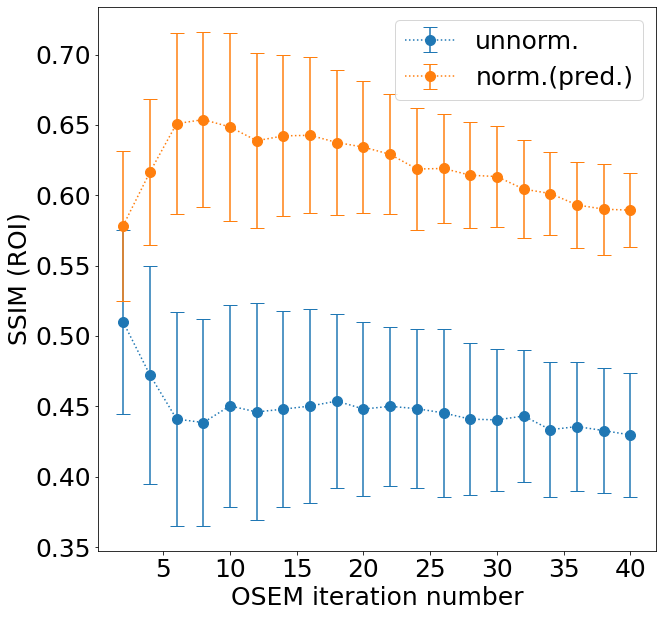

In [51]:
textSize = 25
x = iterList
keys = sorted([int(k) for k in SSIML_in])
y1 = [np.mean(SSIML_in[str(i)]) for i in keys]
yerr1 = [np.std(SSIML_in[str(i)])/2.0 for i in keys]
y2 = [np.mean(SSIML_gen[str(i)]) for i in keys]
yerr2 = [np.std(SSIML_gen[str(i)])/2.0 for i in keys]
figure = plt.figure(figsize=(10,10))
ax = figure.gca()
text = ax.yaxis.get_offset_text()
text.set_size(textSize) # Overkill!
plt.errorbar(x, y1, yerr1, fmt="o:", markersize=10, capsize=7, label=Alabel)
plt.errorbar(x, y2, yerr2, fmt="o:", markersize=10, capsize=7, label=Blabel)
plt.xlabel("OSEM iteration number", fontsize=textSize)
plt.ylabel("SSIM (ROI)", fontsize=textSize)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
# plt.xticks(iterList, fontsize=textSize)
plt.xticks(fontsize=textSize)
plt.yticks(fontsize=textSize)
plt.legend(fontsize=textSize)
plt.show()

## Contrast Recovery Coeffients

$$
contrast = \frac{signal-background}{background}
$$


$$
CRC = \frac{contrast_{image}}{contrast_{ground truth}}
$$

Will it work??

In [52]:
CRC_in = defaultdict(list)
CRC_gen = defaultdict(list)
for iterNum in dataL:
    for idx in dataL[iterNum]:
        x, y = dataL[iterNum][idx]["realB"][1]
        x1 = int(x-lw/2)
        x2 = int(x+lw/2)
        y1 = int(y-lh/2)
        y2 = int(y+lh/2)
        signal_in = np.mean(dataL[iterNum][idx]["realA"][0][y1:y2, x1:x2])
        signal_gen = np.mean(dataL[iterNum][idx]["fakeB"][0][y1:y2, x1:x2])
        signal_gt = np.mean(dataL[iterNum][idx]["realB"][0][y1:y2, x1:x2])
        x1 = int(256/2-bw/2) # background
        x2 = int(256/2+bw/2)
        y1 = int(256/2-bh/2)
        y2 = int(256/2+bh/2)
        background_in = np.mean(dataL[iterNum][idx]["realA"][0][y1:y2, x1:x2])
        background_gen = np.mean(dataL[iterNum][idx]["fakeB"][0][y1:y2, x1:x2])
        background_gt = np.mean(dataL[iterNum][idx]["realB"][0][y1:y2, x1:x2])
        contrast_in = (signal_in - background_in)/background_in
        contrast_gen = (signal_gen - background_gen)/background_gen
        contrast_gt = (signal_gt - background_gt)/background_gt
        CRC_in[iterNum].append(contrast_in/contrast_gt)
        CRC_gen[iterNum].append(contrast_gen/contrast_gt)
CRC_in_avg = np.mean([np.mean(CRC_in[k]) for k in CRC_in if int(k) >= 10])
CRC_gen_avg = np.mean([np.mean(CRC_gen[k]) for k in CRC_gen if int(k) >= 10])
print("mean CRC_in after 10 or more iter: {:.2f}".format(CRC_in_avg))
print("mean CRC_gen after 10 or more iter: {:.2f}".format(CRC_gen_avg))
print("")
print("improved by {:.1f}% (w.r.t input)".format((CRC_gen_avg - CRC_in_avg)/(CRC_in_avg)*100))

mean CRC_in after 10 or more iter: 0.18
mean CRC_gen after 10 or more iter: 0.80

improved by 348.6% (w.r.t input)


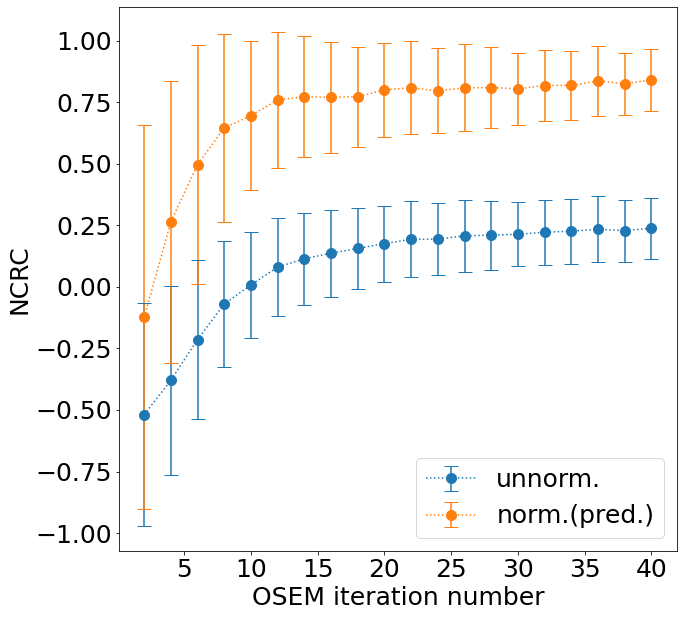

In [53]:
textSize = 25
x = iterList
keys = sorted([int(k) for k in CRC_in])
y1 = [np.mean(CRC_in[str(i)]) for i in keys]
yerr1 = [np.std(CRC_in[str(i)])/2.0 for i in keys]
y2 = [np.mean(CRC_gen[str(i)]) for i in keys]
yerr2 = [np.std(CRC_gen[str(i)])/2.0 for i in keys]
figure = plt.figure(figsize=(10,10))
ax = figure.gca()
text = ax.yaxis.get_offset_text()
text.set_size(textSize) # Overkill!
plt.errorbar(x, y1, yerr1, fmt="o:", markersize=10, capsize=7, label=Alabel)
plt.errorbar(x, y2, yerr2, fmt="o:", markersize=10, capsize=7, label=Blabel)
plt.xlabel("OSEM iteration number", fontsize=textSize)
plt.ylabel("NCRC", fontsize=textSize)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
# plt.xticks(iterList, fontsize=textSize)
plt.xticks(fontsize=textSize)
plt.yticks(fontsize=textSize)
plt.legend(fontsize=textSize)
plt.show()

## Contrast to noise ratio (CNR)

$$
CNR = \frac{contrast}{noise}
$$



In [54]:
CNR_in = defaultdict(list)
CNR_gen = defaultdict(list)
CNR_gt = defaultdict(list)
for iterNum in dataL:
    for idx in dataL[iterNum]:
        x, y = dataL[iterNum][idx]["realB"][1]
        x1l = int(x-lw/2)
        x2l = int(x+lw/2)
        y1l = int(y-lh/2)
        y2l = int(y+lh/2)
        signal_in = np.mean(dataL[iterNum][idx]["realA"][0][y1l:y2l, x1l:x2l])
        signal_gen = np.mean(dataL[iterNum][idx]["fakeB"][0][y1l:y2l, x1l:x2l])
        signal_gt = np.mean(dataL[iterNum][idx]["realB"][0][y1l:y2l, x1l:x2l])
        x1b = int(256/2-bw/2) # background
        x2b = int(256/2+bw/2)
        y1b = int(256/2-bh/2)
        y2b = int(256/2+bh/2)
        background_in = np.mean(dataL[iterNum][idx]["realA"][0][y1b:y2b, x1b:x2b])
        background_gen = np.mean(dataL[iterNum][idx]["fakeB"][0][y1b:y2b, x1b:x2b])
        background_gt = np.mean(dataL[iterNum][idx]["realB"][0][y1b:y2b, x1b:x2b])
        noise_in = np.std(dataL[iterNum][idx]["realA"][0][y1b:y2b, x1b:x2b])/background_in
        noise_gen = np.std(dataL[iterNum][idx]["fakeB"][0][y1b:y2b, x1b:x2b])/background_gen
        noise_gt = np.std(dataL[iterNum][idx]["realB"][0][y1b:y2b, x1b:x2b])/background_gt
        contrast_in = (signal_in - background_in)/background_in
        contrast_gen = (signal_gen - background_gen)/background_gen
        contrast_gt = (signal_gt - background_gt)/background_gt
        CNR_in[iterNum].append(contrast_in/noise_in)
        CNR_gen[iterNum].append(contrast_gen/noise_gen)
        CNR_gt[iterNum].append(contrast_gt/noise_gt)
CNR_in_avg = np.mean([np.mean(CNR_in[k]) for k in CNR_in if int(k) >= 10])
CNR_gen_avg = np.mean([np.mean(CNR_gen[k]) for k in CNR_gen if int(k) >= 10])
CNR_gt_avg = np.mean([np.mean(CNR_gt[k]) for k in CNR_gt if int(k) >= 10])
print("mean CNR_in after 10 or more iter: {:.2f}".format(CNR_in_avg))
print("mean CNR_gen after 10 or more iter: {:.2f}".format(CNR_gen_avg))
print("mean CNR_gt after 10 or more iter: {:.2f}".format(CNR_gt_avg))
print("")
print("improved by {:.1f}% (w.r.t input)".format((CNR_gen_avg - CNR_in_avg)/(CNR_in_avg)*100))




mean CNR_in after 10 or more iter: 0.46
mean CNR_gen after 10 or more iter: 2.10
mean CNR_gt after 10 or more iter: 2.11

improved by 355.0% (w.r.t input)


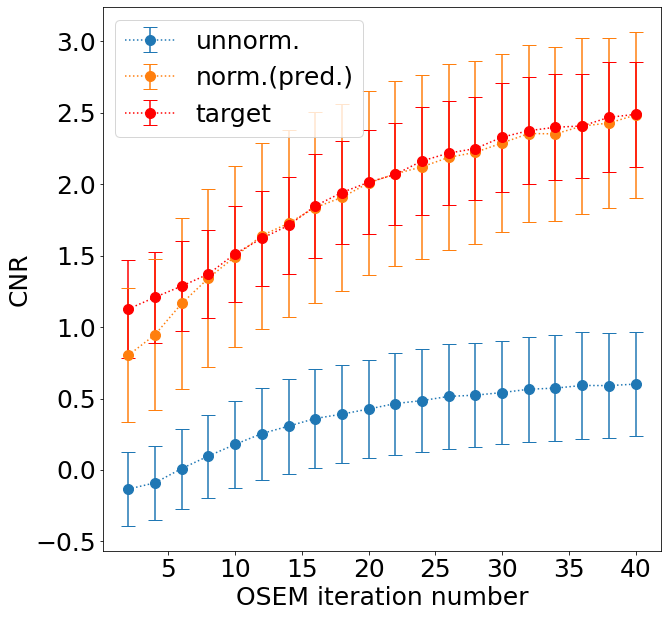

In [55]:
textSize = 25
x = iterList
keys = sorted([int(k) for k in CNR_in])
y1 = [np.mean(CNR_in[str(i)]) for i in keys]
yerr1 = [np.std(CNR_in[str(i)])/2.0 for i in keys]
y2 = [np.mean(CNR_gen[str(i)]) for i in keys]
yerr2 = [np.std(CNR_gen[str(i)])/2.0 for i in keys]
y3 = [np.mean(CNR_gt[str(i)]) for i in keys]
yerr3 = [np.std(CNR_gt[str(i)])/2.0 for i in keys]
figure = plt.figure(figsize=(10,10))
ax = figure.gca()
text = ax.yaxis.get_offset_text()
text.set_size(textSize) # Overkill!
plt.errorbar(x, y1, yerr1, fmt="o:", markersize=10, capsize=7, label=Alabel)
plt.errorbar(x, y2, yerr2, fmt="o:", markersize=10, capsize=7, label=Blabel)
plt.errorbar(x, y3, yerr3, fmt="o:", color="r", markersize=10, capsize=7, label="target")
plt.xlabel("OSEM iteration number", fontsize=textSize)
plt.ylabel("CNR", fontsize=textSize)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
# plt.xticks(iterList, fontsize=textSize)
plt.xticks(fontsize=textSize)
plt.yticks(fontsize=textSize)
plt.legend(fontsize=textSize)
plt.show()